# Fixture Modelling

How many goals are PL teams to score and concede in upcoming fixtures?

See here for some more technical details http://web.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf

## Setup

In [1]:
import pandas as pd
from datetime import timezone
import numpy as np
import scipy.stats
import scipy.optimize
import seaborn as sns

In [2]:
from src.utils.elo import Elo

In [7]:
!ls data/Fantasy-Premier-League

In [3]:
!cd data/Fantasy-Premier-League && git pull # pull latest data

Already up to date.


## Load data

In [4]:
SEASONS = ['2018-19' ,'2019-20','2020-21', '2021-22',]

In [5]:
BASE = 'data/Fantasy-Premier-League'

In [8]:
combined = pd.DataFrame()
for season in SEASONS:
    df = pd.read_csv(f'{BASE}/data/{season}/fixtures.csv',parse_dates=['kickoff_time'])
    df['season'] = season
    combined = df.append(combined)

In [9]:
teams = pd.read_csv(f'{BASE}/data/master_team_list.csv')

the numbers aren't consistent across seasons so we merge on names and come up with our own numbering

In [10]:
def clean_names(combined, teams):    
    with_names = combined.copy()
    for suff in ['_h','_a']:
        with_names = with_names.merge(teams.rename(columns={'team':f"team{suff}",
                                                            "team_name":f'team_name{suff}'}),on = ['season',f'team{suff}'],how='left')
    unique_teams = list(set(with_names["team_name_h"]))
    name_mapping = dict(zip(unique_teams,range(len(unique_teams))))
    with_names['team_h'] = with_names.team_name_h.map(name_mapping) 
    with_names['team_a'] = with_names.team_name_a.map(name_mapping)
    with_names['days_since_fixture'] = (pd.Timestamp.utcnow() - with_names['kickoff_time']).dt.days
    return with_names, name_mapping

In [11]:
df, name_mapping = clean_names(combined, teams)

In [12]:
COLS = ['team_h','team_a','days_since_fixture','team_h_score','team_a_score']

In [13]:
results = df.loc[(df.finished),COLS].copy()
fixtures = df.loc[~df.finished,COLS].copy() 

In [14]:
assert df['team_name_h'].isna().sum() == 0

## Fit model - (1) Dixon-Coles like

We model a game with home/away score (x,y) as being

$\lambda_h = exp(\mu + \gamma + \alpha_{ha} - \alpha_{ad})$

$\lambda_a = exp(\gamma + \alpha_{aa} - \alpha_{hd})$

$p(x,y) = \frac{exp(-\lambda_h)(\lambda_h)^x}{x!} \frac{exp(-\lambda_a)(\lambda_a)^y}{y!}$

Each team has a coefficient for attacking/defending, and there is a fixed effect $\gamma$ and a home-team fixed effect $\mu$. 

In [15]:
def neg_log_likehihood(params, df, discount, n_teams):
    '''
    Based on model above, sum the negative log likelihood, discounted by time
    '''
    mu, gamma, *alpha  = params
    alpha_score = alpha[:n_teams]
    alpha_concede = alpha[n_teams:]
    home = mu +gamma + np.take(alpha_score,df.team_h) - np.take(alpha_concede,df.team_a)
    away = gamma + np.take(alpha_score,df.team_a) - np.take(alpha_concede,df.team_h)
    exp_home = np.exp(home)
    exp_away = np.exp(away)
    neg_log_lik = exp_home - (df["team_h_score"] * home) + exp_away - (df["team_a_score"] * away)
    loss = (np.exp(-discount * df["days_since_fixture"]) * neg_log_lik).sum()
    return loss / df.shape[0]

In [16]:
class DixonColes():
    def __init__(self, name_mapping, discount = 0.01):
        self.name_mapping = name_mapping
        self.n_teams = len(name_mapping)
        self.discount = discount 
        self.params = [0.0 for _ in range(2 + (2*self.n_teams))]
    
    def fit(self, X): 
        '''
        Minimise negative log-likelihood
        '''
        res = scipy.optimize.minimize(
            fun=neg_log_likehihood,
            x0=self.params,
            args=(X, self.discount, self.n_teams),
        )
        mu, gamma, *alpha = res['x']
        alpha_score = alpha[:self.n_teams]
        alpha_concede = alpha[self.n_teams:]
        return mu, gamma, alpha_score, alpha_concede
        


In [17]:
mu, gamma, alpha_score, alpha_concede =  DixonColes(name_mapping).fit(results)

In [18]:
mu

0.008231588778383524

In [19]:
form = pd.DataFrame(data=[name_mapping.keys(),alpha_score, alpha_concede]).T
form.columns = ['team', 'attack','defence']

In [20]:
form['total'] = form.attack + form.defence

This seams like a reasonable form ranking. I think the model is overrating Brentford a bit having never seen them before.

In [ ]:
(form
 .iloc[list(set(fixtures.team_h))]
 .sort_values(by='total',ascending=False))

## Fit Model (2) - ELO

In [23]:
results['outcome'] =(np.clip(results['team_h_score'] -results['team_a_score'],-1,1) + 1) / 2

In [24]:
results = results.sort_values(by='days_since_fixture',ascending=False)

In [ ]:
elo =Elo(results,k_factor=35)
historic_elo, elo_ratings =elo.process_all_fixtures()

## Plot elo over time

In [27]:
inv_mapping = {v:k for k,v in name_mapping.items()}

In [28]:
historic_elo['name'] = historic_elo.team_h.map(inv_mapping)

In [29]:
historic_elo['neg_days_since_fixture'] = historic_elo['days_since_fixture'] * -1

In [30]:
filtered = historic_elo.loc[historic_elo.name.isin(['Chelsea', 'Man City', 'Liverpool','West Ham', 'Man Utd'])]

<AxesSubplot:xlabel='neg_days_since_fixture', ylabel='elo'>

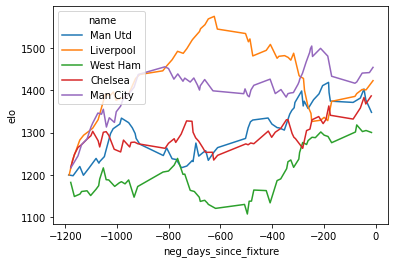

In [31]:
sns.lineplot(data=filtered, hue='name', y='elo', x='neg_days_since_fixture')

In [32]:
form['elo'] =pd.Series(elo_ratings).sort_index()

In [33]:
form.iloc[list(set(fixtures.team_h))].sort_values(by='total',ascending=False)


,team,attack,defence,total,elo
18,Chelsea,0.624224,1.025208,1.649432,1396.549431
15,Liverpool,0.806599,0.417096,1.223695,1413.512958
14,Man City,0.596887,0.578773,1.175661,1425.061435
21,West Ham,0.3584,0.202121,0.560521,1329.357846
10,Arsenal,0.195603,0.234997,0.430601,1323.008556
9,Man Utd,0.374342,-0.04426,0.330082,1347.870564
20,Brentford,0.112791,0.130441,0.243232,1196.358666
19,Crystal Palace,0.162601,0.066452,0.229053,1212.711969
6,Leicester,0.357312,-0.204888,0.152425,1259.717940
12,Brighton,-0.129392,0.213145,0.083753,1231.361833


## Map form onto fixtures

In [34]:
CURRENT_GAMEWEEK = ((df.season == df.season.max()) & (df.finished == True)).sum() // 10 

map on the expected scoring rates

In [35]:
fixtures['score'] = np.exp(mu +gamma + np.take(alpha_score,fixtures.team_h) - np.take(alpha_concede,fixtures.team_a))
fixtures['opp_score'] = np.exp(gamma + np.take(alpha_score,fixtures.team_a) - np.take(alpha_concede,fixtures.team_h))

In [36]:
fixtures['elo_win'] =fixtures.apply(lambda row: elo.win_prob(row['team_h'],row['team_a']),axis=1)

In [37]:
fixtures['team'] = fixtures['team_h'].map(inv_mapping)
fixtures['opp'] = fixtures['team_a'].map(inv_mapping)

We flip home and away fixtures to have all fixtures for all teams in long format

In [38]:
upcoming_difficulties = fixtures[['team','opp','score','elo_win','opp_score','days_since_fixture']]

In [39]:
flipped_difficulties = upcoming_difficulties.copy().rename(columns={'team':'opp',
                                                                    'opp':'team',
                                                                    'score':'opp_score',
                                                                    'opp_score':'score',})
flipped_difficulties['elo_win'] = 1 -flipped_difficulties['elo_win']

In [40]:
assert (upcoming_difficulties.groupby('team')['opp'].count() + upcoming_difficulties.groupby('opp')['team'].count()).max() == 38 - CURRENT_GAMEWEEK

In [41]:
combined_difficulties = upcoming_difficulties.append(flipped_difficulties).reset_index().sort_values(by='days_since_fixture',ascending=False)

In [42]:
combined_difficulties['gw'] = combined_difficulties.groupby('team').days_since_fixture.cumcount() +1 + CURRENT_GAMEWEEK

In [43]:
score_pivot = pd.pivot_table(data=combined_difficulties,values='score',
                             index='team',columns='gw')

In [44]:
defend_pivot = pd.pivot_table(data=combined_difficulties,values='opp_score',
                              index='team',columns='gw')

In [ ]:
elo_pivot = pd.pivot_table(data=combined_difficulties,values='elo_win',
                              index='team',columns='gw')

Filter the data for the next n weeks

In [ ]:
N = 5

In [ ]:
for outcome in ['score','opp_score','elo_win']:
    print(outcome)
    pivot = pd.pivot_table(data=combined_difficulties,values=outcome,
                             index='team',columns='gw')
    n_week = pivot.iloc[:,:N].copy()
    n_week['avg'] = n_week.mean(axis=1)
    sort_dir = outcome == 'opp_score'
    display(n_week
     .sort_values(by='avg',ascending=sort_dir) 
     .style.background_gradient(cmap='Blues'))

In [ ]:
combined_difficulties.pivot(index='team',columns='gw',values='opp').iloc[:,:N]